<a href="https://colab.research.google.com/github/mbhargavi06/Quantum-Annealers-with-Classical-Neural-Networks/blob/main/Main_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cifar_testdata_path  = "/content/drive/MyDrive/NN_Dataset/CIFAR/test_batch"
cifar_traindata_path = "/content/drive/MyDrive/NN_Dataset/CIFAR/data_batch_1"

mnist_testdata_path = '/content/drive/MyDrive/NN_Dataset/MNIST/mnist_test.csv'
mnist_traindata_path = '/content/drive/MyDrive/NN_Dataset/MNIST/mnist_train.csv'

isolet_testdata_path = '/content/drive/MyDrive/NN_Dataset/ISOLET/isolet_test.choir_dat'
isolet_traindata_path = '/content/drive/MyDrive/NN_Dataset/ISOLET/isolet_train.choir_dat'

ucihar_testdata_path = '/content/drive/MyDrive/NN_Dataset/UCIHAR/sa12_test.choir_dat'
ucihar_traindata_path = '/content/drive/MyDrive/NN_Dataset/UCIHAR/sa12_train.choir_dat'

# Helper Functions

In [ ]:
"""
Author: Samuel Bosch
Affiliation: Massachusetts Institute of Technology
Date: 08/14/2023

This module contains several all the helper functions used in this project

This code is the result of research funded by the Defense Advanced Research Projects Agency (DARPA) under agreement No.HR00112109969

Copyright (c) 2023 Samuel Bosch

The author hereby grants to MIT a nonexclusive, worldwide, irrevocable, royalty-free license to exercise any and all rights under copyright, including to reproduce, preserve, distribute and publicly display copies of the thesis, or release the thesis under an open-access license.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.
"""

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import time
from matplotlib import pyplot as plt
import csv
import time
from prettytable import PrettyTable
import struct
from sklearn.preprocessing import StandardScaler



def kron(states_list, device):
    """
    Compute the Kronecker product of all the elements within a list.

    This function uses the torch.kron function to compute the Kronecker product
    of all elements in the input list. The function can handle both 1D states
    and 2D Hamiltonian matrices.

    Parameters
    ----------
    states_list : list
        A list of torch.tensor objects, which can be either 1D states or
        2D Hamiltonian matrices.
    device : torch.device
        The device where the tensors will be allocated.

    Returns
    -------
    torch.tensor
        A tensor representing the Kronecker product of all elements in the
        input list. This tensor can be either 1D or 2D, depending on the
        dimensionality of the input tensors.

    """

    current_state = torch.tensor([[1]]).to(device)
    for i in range(len(states_list)):
        current_state = torch.kron(current_state,states_list[i])
    return current_state


def get_pauli_matrices(device='cpu'):
    """
    Returns the Pauli matrices: I, X, Y, Z.

    Args:
        device: The device where the matrices will be allocated.
        It defaults to cpu, if nothing else is specified

    Returns:
        I, X, Y, Z: The Pauli matrices as pytorch complex tensors
    """
    I = torch.tensor([[1, 0], [0, 1]], dtype=torch.cfloat).to(device)
    X = torch.tensor([[0, 1], [1, 0]], dtype=torch.cfloat).to(device)
    Y = torch.tensor([[0, -1j], [1j, 0]], dtype=torch.cfloat).to(device)
    Z = torch.tensor([[1, 0], [0, -1]], dtype=torch.cfloat).to(device)

    return I, X, Y, Z


def get_quantum_states(device='cpu'):
    """
    Returns the quantum states: zero and one.

    Args:
        device: The device where the states will be allocated.
        It defaults to cpu, if nothing else is specified

    Returns:
        zero, one: The quantum states as pytorch complex tensors
    """
    zero = torch.tensor([[1], [0]], dtype=torch.cfloat).to(device)
    one = torch.tensor([[0], [1]], dtype=torch.cfloat).to(device)

    return zero, one



def generate_list_of_hamiltonians_matrix_form(n, shape, I, X, Z, device):
    """
    This function generates a list of Hamiltonians in matrix form.

    Arguments:
    n: int
       This is the size of the quantum system (number of qubits).

    shape: tuple
       This is the shape of the tensor to be created for storing Hamiltonians.

    I: torch.tensor
       This is the identity matrix.

    X: torch.tensor
       This is the Pauli X (or NOT gate) matrix.

    Z: torch.tensor
       This is the Pauli Z (or phase flip) matrix.

    device: torch.device
       This is the device where the tensors will be stored (CPU or specific GPU).

    Returns:
    Hamiltonians: torch.tensor
       The tensor containing all Hamiltonians in matrix form. The tensor is of
       complex64 type and is located on the specified device.

    The Hamiltonians are generated based on a system with 'n' qubits. For each
    qubit, two Hamiltonians are generated, one with an X gate and one with a Z
    gate at the qubit's position. Then, for each pair of qubits, a Hamiltonian
    is generated with Z gates at both qubits' positions.

    The result is a list of Hamiltonians, each represented as a matrix. This list
    can be used for further calculations in a quantum annealing process.
    """

    # Initialize tensor for Hamiltonians, ensuring the datatype is complex
    Hamiltonians = torch.zeros(shape, device=device).type(torch.complex64)
    # k is a counter for Hamiltonians in the case of two qubits interaction
    k = 2*n-1

    # Loop through each qubit
    for i in range(n):
        # Generate Hamiltonian with an X gate at current qubit position
        gates_in_list_form = n*[I]
        gates_in_list_form[i] = X
        Hamiltonians[i] = kron(gates_in_list_form, device)
        print("Generated Hamiltonian with X at qubit",i, "in tensor form")

        # Generate Hamiltonian with a Z gate at current qubit position
        gates_in_list_form = n*[I]
        gates_in_list_form[i] = Z
        Hamiltonians[i+n] = kron(gates_in_list_form, device)
        print("Generated Hamiltonian with Z at qubit",i, "in tensor form")

    # Generate Hamiltonians for each pair of qubits
    for i in range(n):
        for j in range(i+1,n):
            k += 1
            # Generate Hamiltonian with Z gates at both qubits' positions
            gates_in_list_form = n*[I]
            gates_in_list_form[i] = Z
            gates_in_list_form[j] = Z
            Hamiltonians[k] = kron(gates_in_list_form, device)
            print("Generated Hamiltonian with ZZ at qubits",i,"and",j, "in tensor form")

    return Hamiltonians


def generate_list_of_hamiltonians_symbolic_form(n):
    """
    This function generates a list of Hamiltonians in symbolic form.

    Arguments:
    n: int
       The size of the quantum system (number of qubits).

    Returns:
    Hamiltonians_symbolic: list of lists
       A list where each entry is a symbolic representation of a Hamiltonian.
       Each Hamiltonian is represented as a list of strings, where each string
       corresponds to a gate (I, X, or Z) on a qubit.

    The function generates Hamiltonians for a system with 'n' qubits. For each
    qubit, two Hamiltonians are created, one with an X gate and one with a Z gate
    at the qubit's position. Then, for each pair of qubits, a Hamiltonian is
    created with Z gates at both qubits' positions.

    The result is a list of symbolic Hamiltonians. Each Hamiltonian is represented
    as a list of strings, where each string represents a gate (I for identity, X
    for NOT gate, and Z for phase flip) on a qubit. This list of symbolic
    Hamiltonians can be used for further symbolic calculations or for visualization
    of the Hamiltonians.
    """
    # Initialize the list for symbolic Hamiltonians
    Hamiltonians_symbolic = []

    # Loop through each qubit
    for i in range(n):
        # Generate Hamiltonian with an X gate at the current qubit position
        temp = n*['I']
        temp[i] = 'X'
        Hamiltonians_symbolic.append(temp)

    for i in range(n):
        # Generate Hamiltonian with a Z gate at the current qubit position
        temp = n*['I']
        temp[i] = 'Z'
        Hamiltonians_symbolic.append(temp)

    # Generate Hamiltonians for each pair of qubits
    for i in range(n):
        for j in range(i+1,n):
            # Generate Hamiltonian with Z gates at both qubits' positions
            temp = n*['I']
            temp[i] = 'Z'
            temp[j] = 'Z'
            Hamiltonians_symbolic.append(temp)

    print("Generated the following list of symbolic Hamiltonians:\n", Hamiltonians_symbolic, "\n")

    return Hamiltonians_symbolic



# Helper functions

def is_unitary(M):
    """
    Checks if the input is a unitary matrix.

    Arguments:
    M: torch.tensor
       A 2D tensor representing a matrix.

    Returns:
    bool:
       Returns True if the input matrix is unitary (i.e., if the matrix multiplied
       by its conjugate transpose results in the identity matrix), and False
       otherwise.

    The function first detaches the tensor from its computation graph and converts
    it into a NumPy array. Then it checks if the matrix is unitary by comparing
    the product of the matrix and its conjugate transpose with the identity matrix
    of the same size. The comparison is done within a tolerance defined by
    np.allclose().
    """

    M = M.detach().numpy()
    return np.allclose(np.eye(len(M)), M.dot(M.T.conj()))

def density_matrix_distance(rho,sigma):
    """
    Calculates the Hilbert-Schmidt distance between two density matrices.

    Arguments:
    rho, sigma: torch.tensor
       These are the two density matrices for which the distance is to be calculated.
       Both rho and sigma are 2D tensors.

    Returns:
    distance: torch.tensor
       This is the Hilbert-Schmidt distance between rho and sigma. The distance is
       calculated as: -2*Tr(rho*sigma) + Tr(sigma^2) + Tr(rho^2).

    The function calculates the Hilbert-Schmidt distance, which is a measure of the
    difference between two density matrices. This distance can be used to assess
    the similarity of two quantum states.
    """
    # Calculate the Hilbert-Schmidt distance between rho and sigma

    distance = -2*torch.trace(torch.matmul(rho,sigma)) + torch.trace(torch.matmul(rho,rho)) + torch.trace(torch.matmul(sigma,sigma))
    return -distance


def density_matrix_distance_from_states(rho_states,sigma_states):
    """
    Calculates the Hilbert-Schmidt distance between the density matrices that
    would be formed from two sets of state vectors, without explicitly
    calculating the mixed density matrices.

    Arguments:
    rho_states, sigma_states: torch.tensor
       These are two sets of state vectors from which the density matrices would
       be formed. Both rho_states and sigma_states are 2D tensors with shape
       (N, 2**n), where N is the number of states, and n is the number of qubits.

    Returns:
    distance: torch.tensor
       The Hilbert-Schmidt distance between the density matrices that would be
       formed from rho_states and sigma_states. The distance is calculated as:
       -Tr(rho^2)/N_rho^2 - Tr(sigma^2)/N_sigma^2 + 2*Tr(rho*sigma)/(N_rho*N_sigma).

    The function calculates the Hilbert-Schmidt distance using the state vectors
    directly, without explicitly calculating the mixed density matrices. This
    approach can be more efficient when dealing with large density matrices.
    """

    N_1 = len(rho_states)
    N_2 = len(sigma_states)

    sum_1 = torch.sum(torch.abs(torch.matmul(rho_states.conj(),torch.transpose(rho_states,0,1))**2))
    sum_2 = torch.sum(torch.abs(torch.matmul(sigma_states.conj(),torch.transpose(sigma_states,0,1))**2))
    sum_3 = torch.sum(torch.abs(torch.matmul(rho_states.conj(),torch.transpose(sigma_states,0,1))**2))

    return -sum_1/(N_1**2) - sum_2/(N_2**2) + 2*sum_3/(N_1*N_2)


def state_to_pure_density_matrix(state_vector):
    """
    Converts a quantum state |psi> into a pure density matrix |psi><psi|.

    This function computes the pure density matrix representation of a given
    quantum state. It uses the torch.kron function to compute the outer product
    of the state with its conjugate transpose, resulting in the pure density matrix.

    Parameters
    ----------
    state_vector : torch.tensor
        A 1D tensor representing a quantum state |psi>.

    Returns
    -------
    torch.tensor
        A 2D tensor representing the pure density matrix |psi><psi| of the given state.

    """

    return kron([torch.conj(torch.transpose(state_vector,0,1)), state_vector])

def states_to_pure_density_matrices(state_vectors):
    """
    Converts a list of quantum states into a list of pure density matrices.

    This function computes the pure density matrix representation for a given list of quantum states.
    It iteratively uses the kron function to compute the outer product of each state with its conjugate
    transpose, resulting in a list of pure density matrices.

    Parameters
    ----------
    state_vectors : torch.tensor
        A 2D tensor of size N by 2**n representing a list of quantum states. Each row represents
        a quantum state.

    Returns
    -------
    torch.tensor
        A 3D tensor of size N by 2**n by 2**n representing a list of pure density matrices
        corresponding to the input quantum states.

    Notes
    -----
    This function also prints out the time taken to execute the function.

    """

    start_time = time.time()
    output = kron([torch.conj(torch.transpose(state_vectors[0],0,1)), state_vectors[0]])
    for i in range(1,len(state_vectors)):
        output = torch.stack([output,kron([torch.conj(torch.transpose(state_vectors[i],0,1)), state_vectors[i]])])

    end_time = time.time
    print("Time to run states_to_pure_density_matrices function =", end_time-start_time)

    return output

def states_to_mixed_density_matrix(states):
    """
    Converts a list of quantum states into a mixed density matrix.

    This function creates a mixed density matrix from a list of quantum states by first computing the conjugate
    transpose of the states, and then performing a matrix multiplication with the original states. The result
    is normalized by the number of states.

    Parameters
    ----------
    states : torch.tensor
        A 2D tensor of size N by 2**n, representing a list of quantum states. Each row in the tensor represents
        a quantum state.

    Returns
    -------
    torch.tensor
        A 2D tensor of size 2**n by 2**n representing the mixed density matrix corresponding to the input
        quantum states.
    """

    return torch.matmul(torch.conj(states).transpose(0,1),states)/len(states)

def is_valid_quantum_state(psi):
    """
    Checks if a vector represents a valid quantum state.

    Arguments:
    psi: array-like
       The vector to be checked. It can be a list, numpy array, or tensor
       representing a quantum state.

    Returns:
    bool:
       True if the input vector is a valid quantum state, i.e., if it is a
       normalized vector (its norm is 1) and all its elements are complex numbers.
       False otherwise.

    The function first converts the input to a tensor, and then calculates the
    sum of the squares of the absolute values of the vector elements (which
    corresponds to the norm squared of a quantum state). The real part of this
    sum should be 1, and the imaginary part should be 0 for a valid quantum state.
    If the input does not satisfy these conditions, the function prints the square
    root of the sum (which is the norm of the state) and returns False.
    """

    psi = torch.tensor(psi)
    real = np.real(torch.sum(psi.conj()*psi).numpy())
    imaginary = np.imag(torch.sum(psi.conj()*psi).numpy())
    if np.isclose(real,1) and np.isclose(imaginary,0):
        return True
    else:
        sum_elements = 0
        for i in range(len(psi)):
            sum_elements += torch.abs(psi[i])**2
        print(torch.sqrt(sum_elements))
        return False

def get_density_for_input(input, net, device, m, steps):
    """
    Calculates the density matrix corresponding to the final quantum state
    generated by the neural network.

    Arguments:
    input: torch.tensor
       The input tensor for the neural network. It should have either 3 or 4 dimensions.
    net: torch.nn.Module
       The neural network used to process the input.
    device: torch.device
       The device (CPU or GPU) on which calculations are to be performed.
    m: int
       The number of trainable parameters for each time step in the neural network.
    steps: int
       The number of time steps in the quantum system's evolution.

    Returns:
    torch.tensor:
       The density matrix corresponding to the final quantum state. If the input has
       3 dimensions, the output is a 2D tensor representing a single density matrix.
       If the input has 4 dimensions, the output is a 3D tensor representing a set
       of density matrices.

    The function first applies the neural network to the input to get the values of
    the activation functions. These values are then used to compute the final quantum
    states. The method for computing the final states depends on whether symbolic
    operations are being used. Finally, the function computes and returns the
    density matrices corresponding to these final states.
    """

    if len(input.shape) == 3:
        nn_output = net(input).type(torch.complex64)
        activation_functions = torch.reshape(nn_output,(1,m,steps))
        if use_symbolic_operations:
            input_to_density_matrix = state_to_pure_density_matrix(embedding.get_psi_final_symbolic(activation_functions, T, steps, n, trotter_number, device), device)
        else:
            input_to_density_matrix = state_to_pure_density_matrix(embedding.get_psi_final(activation_functions, T, steps, n), device)
        return input_to_density_matrix
    elif len(input.shape) == 4:
        nn_output = net(input).type(torch.complex64)
        activation_functions = torch.reshape(nn_output,(len(input),m,steps))
        if use_symbolic_operations:
            input_to_density_matrices = states_to_pure_density_matrices(embedding.get_psi_final_symbolic(activation_functions, T, steps, n, trotter_number, device), device)
        else:
            input_to_density_matrices = states_to_pure_density_matrices(embedding.get_psi_final(activation_functions, T, steps, n), device)
        return input_to_density_matrices
    else:
        print("Error! Input to get_density_for_input() function seems to be wrong.")

def get_state_for_input(input, net, m, n, steps, use_symbolic_operations, embedding, T, trotter_number, device, Hamiltonians_symbolic):
    """
    Calculates the final quantum state generated by the neural network for the given input.

    Arguments:
    input: torch.tensor
       The input tensor for the neural network. It should have either 3 or 4 dimensions.
    net: torch.nn.Module
       The neural network used to process the input.
    m: int
       The number of trainable parameters for each time step in the neural network.
    n: int
       The number of qubits in the quantum system.
    steps: int
       The number of time steps in the quantum system's evolution.
    use_symbolic_operations: bool
       If True, symbolic operations will be used to compute the final quantum state.
    embedding: object
       The embedding that defines the function used to compute the final quantum state.
    T: float
       The total time for the quantum system's evolution.
    trotter_number: int
       The number of Trotter steps used in the simulation.
    device: torch.device
       The device (CPU or GPU) on which calculations are to be performed.
    Hamiltonians_symbolic: list of str
       The list of Hamiltonians in symbolic form.

    Returns:
    torch.tensor:
       The final quantum state. If the input has 3 dimensions, the output is a 1D
       tensor representing a single quantum state. If the input has 4 dimensions,
       the output is a 2D tensor representing a set of quantum states.

    The function first applies the neural network to the input to get the values of
    the activation functions. These values are then used to compute the final quantum
    states. The method for computing the final states depends on whether symbolic
    operations are being used.
    """

    if len(input.shape) == 3:
        nn_output = net(input).type(torch.complex64)
        activation_functions = torch.reshape(nn_output,(1,m,steps))
        if use_symbolic_operations:
            input_to_density_matrix = embedding.get_psi_final_symbolic(activation_functions)
        else:
            input_to_density_matrix = embedding.get_psi_final(activation_functions)
        return input_to_density_matrix
    elif len(input.shape) == 4:
        nn_output = net(input).type(torch.complex64)
        activation_functions = torch.reshape(nn_output,(len(input),m,steps))
        if use_symbolic_operations:
            input_to_density_matrices = embedding.get_psi_final_symbolic(activation_functions, T, m, steps, n, trotter_number, device, Hamiltonians_symbolic)
        else:
            input_to_density_matrices = embedding.get_psi_final(activation_functions)
        return input_to_density_matrices
    else:
        print("Error! Input to get_density_for_input() function seems to be wrong.")



def classify(input, net, rho, sigma):
    """
    Classifies the input data based on the Hilbert-Schmidt distance between the
    density matrix generated from the input and two reference density matrices rho and sigma.

    Arguments:
    input: torch.tensor
       The input tensor for the neural network. This tensor represents the data to be classified.
    net: torch.nn.Module
       The neural network used to process the input.
    rho: torch.tensor
       The first reference density matrix used for classification.
    sigma: torch.tensor
       The second reference density matrix used for classification.

    Returns:
    int:
       The class label of the input. If the density matrix generated from the input is closer
       to sigma than to rho, returns 1. Otherwise, returns 0.

    The function first applies the neural network to the input to get the density matrix.
    Then it computes the Hilbert-Schmidt distances between this density matrix and the
    reference density matrices rho and sigma. If the distance to sigma is larger than the
    distance to rho, the function classifies the input as class 1; otherwise, it classifies
    it as class 0.
    """

    density_matrix = get_density_for_input(input, net)
    if density_matrix_distance(density_matrix,sigma).real > density_matrix_distance(density_matrix,rho).real:
        return 1
    else:
        return 0


def classify_multiclass(input, net, density_matrices_or_states, calculate_density_matrices, T, m, n, steps, trotter_number, device, Hamiltonians_symbolic, use_symbolic_operations, embedding, K):
    """
    Classifies the input data into one of K classes based on the Hilbert-Schmidt distance
    between the density matrix generated from the input and the reference density matrices
    or states for each class.

    Arguments:
    input: torch.tensor
       The input tensor for the neural network. This tensor represents the data to be classified.
    net: torch.nn.Module
       The neural network used to process the input.
    density_matrices_or_states: list of torch.tensor
       The list of reference density matrices or states used for classification.
    calculate_density_matrices: bool
       If True, the function calculates the density matrices for the input.
    T: float
       The total time for the quantum system's evolution.
    m: int
       The number of trainable parameters for each time step in the neural network.
    n: int
       The number of qubits in the quantum system.
    steps: int
       The number of time steps in the quantum system's evolution.
    trotter_number: int
       The number of Trotter steps used in the simulation.
    device: torch.device
       The device (CPU or GPU) on which calculations are to be performed.
    Hamiltonians_symbolic: list of str
       The list of Hamiltonians in symbolic form.
    use_symbolic_operations: bool
       If True, symbolic operations will be used to compute the final quantum state.
    embedding: object
       The embedding that defines the function used to compute the final quantum state.
    K: int
       The number of classes.

    Returns:
    int:
       The class label of the input. The function classifies the input as the class whose reference
       density matrix or state is closest (in terms of the Hilbert-Schmidt distance) to the density matrix
       generated from the input.

    The function first applies the neural network to the input to get the density matrix.
    Then it computes the Hilbert-Schmidt distances between this density matrix and the
    reference density matrices or states for each class. It assigns the class label of the closest
    reference density matrix or state to the input.
    """

    if len(input.shape):
        input = input.reshape((1,input.shape[0],input.shape[1],input.shape[2]))

    if calculate_density_matrices:
        density_matrix = get_density_for_input(input, net)
        min_distance = 2
        prediction = -1
        for i in range(K):
            distance = -density_matrix_distance(density_matrix,density_matrices_or_states[i]).real
            if distance < min_distance:
                min_distance = distance
                prediction = i
        if prediction == -1:
            print("An error has occured. No class was predicted in classify() function!")
        else:
            return prediction
    else:
        state = get_state_for_input(input, net, m, n, steps, use_symbolic_operations, embedding, T, trotter_number, device, Hamiltonians_symbolic)
        min_distance = 2
        prediction = -1
        for i in range(K):
            distance = -density_matrix_distance_from_states(state,density_matrices_or_states[i])
            if distance < min_distance:
                min_distance = distance
                prediction = i
        if prediction == -1:
            print("An error has occured. No class was predicted in classify() function!")
        else:
            return prediction


def classical_classify(input, classical_net):
    """
    Classifies the input data using a classical neural network.

    Arguments:
    input: torch.tensor
       The input tensor for the neural network. This tensor represents the data to be classified.
    classical_net: torch.nn.Module
       The classical neural network used to process the input.

    Returns:
    list of int:
       A list of class labels for each instance in the input. The label for each instance is
       the index of the maximum output among all output units of the neural network.

    This function applies the classical neural network to the input data, computes the output
    of each unit in the output layer, and then identifies the index of the unit with the maximum
    output. This index is used as the class label for the input.
    """

    return list(torch.argmax(classical_net(input),dim=1).detach().cpu().numpy())


def state_overlap(x, y):
    """
    Computes the overlap between two quantum states.

    Arguments:
    x, y: torch.tensor
       The quantum states, represented as 1D tensors.

    Returns:
    torch.tensor:
       The overlap between the two quantum states, calculated as the norm of their dot product.

    The overlap is a measure of similarity between two quantum states. It is computed by taking
    the dot product of the two state vectors, and then calculating the norm of this product. If the
    states are identical, the overlap will be 1, and if they are orthogonal, the overlap will be 0.
    """
    return torch.linalg.norm(torch.dot(x.flatten().conj(),y.flatten()))



def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        params = parameter.numel()
        table.add_row([name, params])
        total_params+=params
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params


class embedder:
    """
    A class used to embed the Hamiltonians, simulate them and calculate the final state.

    ...

    Attributes
    ----------
    n : int
        number of qubits
    Hamiltonians : list of torch.Tensor
        hamiltonians available for use in the system
    m : int
        number of Hamiltonians
    T : float
        Time during which hamiltonians are applied
    steps : int
        Number of discrete values of the activation functions for each hamiltonian
    trotter_number : int
        Number of trotter steps

    Methods
    -------
    simulate_hamiltonians(Hamiltonians, activation_functions, n, m, h_bar, device, trotter_number, steps):
        Simulates the Hamiltonians using the activation functions produced by the neural network.

    get_psi_final(activation_functions, T, steps, n):
        Evaluates the Hamiltonians to get the final state for each input.

    get_psi_final_symbolic(activation_functions, T, m, steps, n, trotter_number, device, Hamiltonians_symbolic):
        Evaluates the Hamiltonians using symbolic operations and Trotter approximation to get the final state for each input.

    symbolic_operation(paulis, state):
        Calculates the approximation of e^(i*detla_t*H)*state using symbolic operations.
    """

    def __init__(self, n, Hamiltonians, m, T, steps, trotter_number):
        self.n = n # number of qubits
        self.Hamiltonians = Hamiltonians # hamiltonians available for use in the system
        self.m = len(Hamiltonians)
        self.T = T # Time during which hamiltonians are applied
        self.steps = steps # Number of discrete values of the activation functions for each hamiltonian
        self.trotter_number = trotter_number


    def simulate_hamiltonians(self, Hamiltonians, activation_functions, n, m, h_bar, device, trotter_number, steps):
        """
        Simulates Hamiltonians given activation functions and a set of system Hamiltonians.

        This function computes the Hamiltonian H(t) for each input in the dataset by applying the activation
        functions produced by the neural network on the system's available Hamiltonians. The function returns
        a tensor with all the values of H(t) for all the different inputs which are used to run the quantum circuits.

        Parameters
        ----------
        Hamiltonians : torch.tensor
            A 2D tensor representing the Hamiltonians available to the system. Each Hamiltonian is a square
            matrix of dimension 2**n by 2**n.

        activation_functions : torch.tensor
            A 3D tensor representing the activation functions produced by the neural network. The tensor has a
            shape of (number of datapoints) x m x steps.

        n : int
            The exponent used to compute the dimension of each Hamiltonian. Each Hamiltonian is a square matrix
            of dimension 2**n by 2**n.

        m : int
            The number of Hamiltonians available to the system.

        h_bar : float
            The reduced Planck constant.

        device : torch.device
            The device where the tensors will be allocated.

        trotter_number : int
            The number of Trotter steps to be used in the simulation.

        steps : int
            The number of time steps in the simulation.

        Returns
        -------
        torch.tensor
            A 3D tensor with shape (number of datapoints) x (Hamiltonian dimensions 2**n by 2**n) x steps, representing
            the Hamiltonian H(t) for each input in the dataset.
        """

        N = len(activation_functions)

        M1 = activation_functions.transpose(1,2).flatten(0,1)
        M2 = Hamiltonians.flatten(1,2)
        M1M2 = torch.matmul(M1, M2)
        return M1M2.reshape(N,2**n,2**n)#.transpose(0,1)

    def get_psi_final(self, activation_functions, T, steps, n):
        """
        Computes the final quantum state for each input data.

        This function applies the Hamiltonian H(t) at each time step to the initial state |00...0> to
        compute the final state for each input data. The Hamiltonian H(t) at each time step is computed
        by applying the activation functions produced by the neural network on the system's Hamiltonians.

        Parameters
        ----------
        activation_functions : torch.tensor
            A 3D tensor representing the activation functions produced by the neural network. The tensor has
            a shape of (dataset_length) x m x steps.

        T : float
            The total time of the simulation.

        steps : int
            The number of time steps in the simulation.

        n : int
            The exponent used to compute the dimension of each Hamiltonian and each quantum state.
            Each Hamiltonian is a square matrix of dimension 2**n by 2**n, and each quantum state
            is a vector of length 2**n.

        Returns
        -------
        torch.tensor
            A 2D tensor with shape (number of datapoints) x (2**n), representing the final quantum state
            for each input data.
        """

        delta_t = T/steps

        psi_at_t = torch.zeros((activation_functions.shape[0],2**n)).type(torch.complex64).to(device)
        psi_at_t.transpose(0,1)[0,:] = 1

        #for i in range(steps):
        for i in range(steps-1,-1,-1): # loops through T/delta_t steps
            M = activation_functions.transpose(0,2)[i].transpose(0,1)
            M = M.reshape(M.shape[0],M.shape[1],1)
            Hamiltonians_list = self.simulate_hamiltonians(Hamiltonians, M, n, m, h_bar, device, trotter_number, steps)

            psi_at_t = torch.einsum("nbh,nb->nh", (torch.matrix_exp(-1j*delta_t/h_bar*Hamiltonians_list), psi_at_t))

        return psi_at_t


    def get_psi_final_symbolic(self, activation_functions, T, m, steps, n, trotter_number, device, Hamiltonians_symbolic):
        """
        Computes the final quantum state for each input data using symbolic Hamiltonians.

        This function applies the Hamiltonian H(t) at each time step to the initial state |00...0> to
        compute the final state for each input data. The Hamiltonian H(t) at each time step is computed
        by applying the activation functions produced by the neural network on the symbolic Hamiltonians
        of the system. It uses the Trotter approximation to compute the exponential of each Hamiltonian.

        Parameters
        ----------
        activation_functions : torch.tensor
            A 3D tensor representing the activation functions produced by the neural network. The tensor has
            a shape of (dataset_length) x m x steps.

        T : float
            The total time of the simulation.

        m : int
            The number of Hamiltonians available to the system.

        steps : int
            The number of time steps in the simulation.

        n : int
            The exponent used to compute the dimension of each Hamiltonian and each quantum state.
            Each Hamiltonian is a square matrix of dimension 2**n by 2**n, and each quantum state
            is a vector of length 2**n.

        trotter_number : int
            The number of slices in the Trotter approximation.

        device : str
            The device where the tensors are stored ("cpu", "gpu").

        Hamiltonians_symbolic : list of torch.tensor
            A list of 2D tensors representing the symbolic Hamiltonians of the system.

        Returns
        -------
        torch.tensor
            A 2D tensor with shape (number of datapoints) x (2**n), representing the final quantum state
            for each input data.
        """

        delta_t = T/steps

        psi_at_t = torch.zeros(len(activation_functions),2**n).type(torch.complex64).to(device)
        psi_at_t.transpose(0,1)[0] = torch.ones(len(activation_functions))
        psi_at_t = torch.reshape(psi_at_t, [len(activation_functions)]+n*[2])

        ascii_letters_without_n = "abcdefghijklmopqrstuvwxyz"
        Einstein_string = "n,n"+ascii_letters_without_n[0:n]+"->n"+ascii_letters_without_n[0:n]


        for step in range(steps-1,-1,-1): # loops through T/delta_t steps
            M = activation_functions.transpose(0,2)[step].transpose(0,1)#[k]
            for j in range(trotter_number):
                for i in range(m):
                    psi_at_t = torch.einsum(Einstein_string,torch.cos(0.5/trotter_number*delta_t*M[:,i]),psi_at_t) - 1j*torch.einsum(Einstein_string,torch.sin(0.5/trotter_number*delta_t*M[:,i]),self.symbolic_operation(Hamiltonians_symbolic[i],psi_at_t))
                for i in range(m-1,-1,-1):
                    psi_at_t = torch.einsum(Einstein_string,torch.cos(0.5/trotter_number*delta_t*M[:,i]),psi_at_t) - 1j*torch.einsum(Einstein_string,torch.sin(0.5/trotter_number*delta_t*M[:,i]),self.symbolic_operation(Hamiltonians_symbolic[i],psi_at_t))

        return psi_at_t.reshape(len(activation_functions),2**n)

    def symbolic_operation(self, paulis, state):
        """
        Calculate the approximation of e^(i*delta_t*H)*state using symbolic operations.

        This function applies a series of transformations to the quantum state
        based on the Pauli matrices represented by the input 'paulis'. These transformations
        correspond to applying quantum gates represented by the Pauli matrices.

        Parameters
        ----------
        paulis : list of str
            A list of strings where each string represents a Pauli matrix (X, Y, Z) or the identity matrix (I).
            These are used to represent the different quantum gates that will be applied to the state.
        state : torch.Tensor
            A tensor representing the state of a quantum system. It is manipulated by the function
            based on the 'paulis' input.

        Returns
        -------
        state : torch.Tensor
            The state of the quantum system after the symbolic operations have been applied.

        Note
        ----
        In the quantum computing context, 'X', 'Y', 'Z', and 'I' are shorthand for the Pauli-X, Pauli-Y,
        Pauli-Z, and Identity matrices, respectively. These are fundamental quantum gates in quantum computing.

        Raises
        ------
        ValueError
            If the dimension of the state does not match with the number of Pauli matrices.
        """

        if len(state.shape) != len(paulis)+1:
            print("Error! paulis don't match state in dimension")

        state_list = [state]

        for i in range(len(paulis)):
            if paulis[i] == 'I':
                continue
            elif 'X' in paulis[i]:
                state = state.transpose(0,i+1)
                state = state[[1,0]]
                state = state.transpose(0,i+1)
            elif 'Y' in paulis[i]:
                state = 1j*state.transpose(0,i+1)
                state = state[[1,0]]
                temp = torch.ones(state.shape).type(state.type()).to(state.device)
                temp[0] = -1*temp[0]
                state = state*temp
                state = state.transpose(0,i+1)
            elif 'Z' in paulis[i]:
                state = state.transpose(0,i+1)
                ###state[1] = -1*state[1] # this doesn't work
                temp = torch.ones(state.shape).type(state.type()).to(state.device)
                temp[1] = -1*temp[1]
                state = state*temp
                state = state.transpose(0,i+1)

            if 'i' in paulis[i]:
                state = 1j*state
            if '-' in paulis[i]:
                state = -1*state
        return state


def read_data_MNIST(file_name, classes_accepted, device):
    """
    Reads and prepares MNIST data from a CSV file.

    This function reads MNIST data from a CSV file, filters the data for the specified classes,
    and converts the data to a tensor suitable for training a PyTorch model.

    Parameters
    ----------
    file_name : str
        The name of the CSV file containing the MNIST data.

    classes_accepted : list
        The list of class labels to filter the data. Only the data that belongs to these classes
        will be returned.

    device : str
        The device where the tensors are stored ("cpu", "gpu").

    Returns
    -------
    tuple of torch.tensor and list
        A tuple containing a 4D tensor with shape (number of images, number of color channels, image height, image width)
        representing the MNIST images, and a list of class labels for each image.
    """

    X = []
    Y = []
    with open(file_name, newline='') as csvfile:
        reader = csv.DictReader(csvfile)
        for row in reader:
            #print(row)
            if 'label' in row and row['label'] in classes_accepted:
                Y.append(int(list(row.values())[0]))
                X.append([int(k) for k in list(row.values())[1:]])
    return torch.reshape(torch.tensor(X),(len(X),1,28,28)).float().to(device), Y


def read_CIFAR(filename, classes_accepted, device):
    """
    Reads and prepares CIFAR data from a binary file.

    This function reads CIFAR data from a binary file, filters the data for the specified classes,
    and converts the data to a tensor suitable for training a PyTorch model.

    Parameters
    ----------
    filename : str
        The name of the binary file containing the CIFAR data.

    classes_accepted : list
        The list of class labels to filter the data. Only the data that belongs to these classes
        will be returned.

    device : str
        The device where the tensors are stored ("cpu", "gpu").

    Returns
    -------
    tuple of torch.tensor and list
        A tuple containing a 4D tensor with shape (number of images, number of color channels, image height, image width)
        representing the CIFAR images, and a list of class labels for each image.
    """

    def unpickle(filename):
        import pickle
        with open(filename, 'rb') as fo:
            dict = pickle.load(fo, encoding='bytes')
        return dict

    data = unpickle(filename)
    Y = data[b'labels']
    X = data[b'data']

    Y_filtered = []
    X_filtered = []
    for i in range(len(Y)):
        if str(Y[i]) in classes_accepted:
            X_filtered.append(X[i])
            Y_filtered.append(Y[i])

    return torch.FloatTensor(X_filtered).reshape((len(X_filtered),3,32,32)).to(device), Y_filtered


def readChoirDat(filename, classes_accepted):
    """
    Reads and prepares Choir data from a binary file.

    This function reads Choir data from a binary file, processes the data, and
    stores it in a list format.

    Parameters
    ----------
    filename : str
        The name of the binary file containing the Choir data.

    classes_accepted : list
        The list of class labels to filter the data. The data that belongs to these classes
        will be included in the output.

    Returns
    -------
    tuple
        A tuple containing the number of features, number of classes, a list of data points (X),
        and a list of corresponding labels (y).
    """

    with open(filename, mode='rb') as f:
        nFeatures = struct.unpack('i', f.read(4))[0]
        nClasses = struct.unpack('i', f.read(4))[0]
        X = []
        y = []
        while True:
            newDP = []
            for i in range(nFeatures):
                v_in_bytes = f.read(4)
                if v_in_bytes is None or len(v_in_bytes) == 0:
                    return nFeatures, nClasses, X, y
                v = struct.unpack('f', v_in_bytes)[0]
                newDP.append(v)
            l = struct.unpack('i', f.read(4))[0]
            X.append(newDP)
            y.append(l)
    return nFeatures, nClasses, X, y



def imshow(img):
    """
    Displays an image.

    This function takes an image as input, normalizes it, converts it to a numpy array, and displays it using matplotlib.

    Parameters
    ----------
    img : torch.Tensor
        The image tensor to be displayed.

    Returns
    -------
    None
        This function does not return a value. It's used for its side effect of displaying an image.

    Notes
    -----
    The image is first normalized by rescaling the pixel values from [-1, 1] to [0, 1].
    Then, it's converted to a numpy array, transposed for correct dimension order, and displayed using matplotlib's imshow function.
    """

    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.rcParams["figure.figsize"] = (15,8)
    plt.show()


def nn_loss(nn_input, labels, net, m, n, steps, K, T, save_data, calculate_density_matrices, use_symbolic_operations, embedding, Hamiltonians, Hamiltonians_symbolic, h_bar, device, trotter_number):
    """
    Calculates the loss of the neural network, taking into account the simulation of the entire quantum annealer.

    This function calculates the loss of the neural network by using the network's output for
    the given input dataset, then transforming the output with a quantum annealer simulation.
    The function calculates the distance between the transformed output and the expected output labels.
    The larger the distance, the larger the loss.

    Parameters
    ----------
    nn_input : torch.Tensor
        The input data for the neural network.
    labels : list
        The expected output labels for the input data.
    net : torch.nn.Module
        The neural network model to be trained.
    m : int
        The number of Hamiltonians used in the quantum system.
    n : int
        The number of qubits in the quantum system.
    steps : int
        The number of steps for the Hamiltonian evolution.
    K : int
        The number of classes in the data.
    T : float
        Total time for the Hamiltonian evolution.
    save_data : bool
        Whether to save the gradients.
    calculate_density_matrices : bool
        Whether to calculate density matrices in the quantum simulation.
    use_symbolic_operations : bool
        Whether to use symbolic operations in the quantum simulation.
    embedding : embedder
        The embedder object for embedding the activation functions into the quantum state.
    Hamiltonians : list
        List of Hamiltonians used in the quantum system.
    Hamiltonians_symbolic : list
        List of symbolic Hamiltonians used in the quantum system.
    h_bar : float
        The reduced Planck constant value.
    device : str
        The device where the calculations will be performed ('cpu' or 'cuda').
    trotter_number : int
        The number of divisions for the Trotter-Suzuki approximation in the quantum simulation.

    Returns
    -------
    max_loss : torch.Tensor
        The maximum loss calculated from the distances between the transformed outputs and the expected outputs.
    classes_density_matrices_or_states : list
        The density matrices or states for each class after the transformation.
    activation_functions : torch.Tensor
        The output of the neural network reshaped into the form of activation functions for the quantum simulation.

    Note
    ----
    The function uses either the full density matrix or just the states depending on the 'calculate_density_matrices' parameter.
    It also uses either symbolic operations or not depending on the 'use_symbolic_operations' parameter.

    Raises
    ------
    ValueError
        If 'calculate_density_matrices' and 'use_symbolic_operations' are both True, as symbolic operations
        should not be used with full density matrices.
    """

    nn_output = net(nn_input).type(torch.complex64)
    activation_functions = torch.reshape(nn_output,(len(nn_output),m,steps))
    if save_data: # Only save the gradients (which takes much memmery) if needed
        activation_functions.retain_grad()


    classes_locations = []
    classes_density_matrices_or_states = []
    losses = (torch.zeros((K,K))-2).type(torch.complex64)

    if calculate_density_matrices:
        if use_symbolic_operations:
            print("Error! There is no point in using symbolic operations together with full density matrices!")
            return -1

        for i in range(K):
            classes_locations.append(np.where(np.array(labels) == i)[0].tolist())
            classes_density_matrices_or_states.append(states_to_mixed_density_matrix(embedding.get_psi_final(activation_functions[classes_locations[i]], T, steps, n)))

        for i in range(1,K):
            for j in range(i):
                losses[i,j] = density_matrix_distance(classes_density_matrices_or_states[i],classes_density_matrices_or_states[j])

        max_loss = torch.max(losses.real)
        return max_loss, classes_density_matrices_or_states, activation_functions

    else:
        for i in range(K):
            classes_locations.append(np.where(np.array(labels) == i)[0].tolist())
            if use_symbolic_operations:
                classes_density_matrices_or_states.append(
                    embedding.get_psi_final_symbolic(
                        activation_functions[classes_locations[i]],
                        T,
                        m,
                        steps,
                        n,
                        trotter_number,
                        device,
                        Hamiltonians_symbolic
                    )
                )
            else:
                classes_density_matrices_or_states.append(embedding.get_psi_final(activation_functions[classes_locations[i]],T, steps))

        for i in range(1,K):
            for j in range(i):
                if use_symbolic_operations:
                    losses[i,j] = density_matrix_distance_from_states(
                        embedding.get_psi_final_symbolic(
                            activation_functions[classes_locations[i]],
                            T,
                            m,
                            steps,
                            n,
                            trotter_number,
                            device,
                            Hamiltonians_symbolic
                        ),
                        embedding.get_psi_final_symbolic(
                            activation_functions[classes_locations[j]],
                            T,
                            m,
                            steps,
                            n,
                            trotter_number,
                            device,
                            Hamiltonians_symbolic
                        )
                    )
                else:
                    losses[i,j] = density_matrix_distance_from_states(embedding.get_psi_final(activation_functions[classes_locations[i]]),embedding.get_psi_final(activation_functions[classes_locations[j]]))
        max_loss = torch.max(losses.real)

        return max_loss, classes_density_matrices_or_states, activation_functions



class Classical_Net_conv(nn.Module):
    """
    Classical Convolutional Neural Network (CNN) model.

    This class defines a Convolutional Neural Network architecture for classification tasks.
    The architecture consists of two convolutional layers, followed by two fully connected layers,
    and finally an output layer. Activation functions used are ReLU and the pooling operation is MaxPooling.
    The network's architecture varies slightly based on the dataset used (MNIST or other).

    Parameters
    ----------
    nn_input_dimensions : int
        The dimension of the input data.
    dataset : str
        The dataset that the network will be trained on. The accepted values are "MNIST" or other.
        The architecture of the network changes slightly depending on the dataset used.
    K : int
        The number of classes in the classification task.

    Attributes
    ----------
    conv1 : torch.nn.Conv2d
        The first convolutional layer.
    pool : torch.nn.MaxPool2d
        The max pooling layer.
    conv2 : torch.nn.Conv2d
        The second convolutional layer.
    fc1 : torch.nn.Linear
        The first fully connected layer.
    fc2 : torch.nn.Linear
        The second fully connected layer.
    fc3 : torch.nn.Linear
        The third fully connected layer which is the output layer of the network.

    Methods
    -------
    forward(x)
        Performs a forward pass through the network.
    """

    def __init__(self, nn_input_dimensions, dataset, K):
        super(Classical_Net_conv, self).__init__()
        # kernel
        # an affine operation: y = Wx + b
        self.nn_input_dimensions = nn_input_dimensions
        self.dataset = dataset
        self.K = K

        if dataset == "MNIST":
            colors = 1
            input_first_layer_size = 16*4*4
        else:
            colors = 3
            input_first_layer_size = 16*5*5
        self.conv1 = nn.Conv2d(colors, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(input_first_layer_size, 120) # 28x28 from image dimension
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, K)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        return x


class Classical_Net_simple(nn.Module):
    """
    Simple Classical Neural Network model.

    This class defines a simple neural network architecture for classification tasks.
    The architecture consists of two fully connected layers and utilizes ReLU and Tanh activation functions.

    Parameters
    ----------
    nn_input_dimensions : int
        The dimension of the input data.
    dataset : str
        The dataset that the network will be trained on.
    K : int
        The number of classes in the classification task.

    Attributes
    ----------
    fc1 : torch.nn.Linear
        The first fully connected layer.
    fc2 : torch.nn.Linear
        The second fully connected layer which is the output layer of the network.

    Methods
    -------
    forward(x)
        Performs a forward pass through the network.
    """

    def __init__(self, nn_input_dimensions, dataset, K):
        super(Classical_Net_simple, self).__init__()
        # kernel
        # an affine operation: y = Wx + b
        self.dataset = dataset
        self.K = K
        self.nn_input_dimensions = nn_input_dimensions

        self.fc1 = nn.Linear(nn_input_dimensions, 120)  # 28x28 from image dimension
        self.fc2 = nn.Linear(120, K)

    def forward(self, x):
        x = torch.flatten(x, 1) # flatten all dimensions except the batch dimension
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        x = torch.tanh(x)

        return x


class Hybrid_Net_simple(nn.Module):
    """
    Simple Hybrid Neural Network model.

    This class defines a simple hybrid neural network architecture that is used in conjunction with a quantum annealer.
    The network is designed to output the annealing schedule for the quantum annealer, rather than predicting the output classes directly.

    Parameters
    ----------
    nn_input_dimensions : int
        The dimension of the input data.
    m : int
        The number of variables in the quantum system.
    steps : int
        The number of steps in the annealing schedule.
    hidden_layer_size : int
        The size of the hidden layer in the neural network.
    dataset : str
        The dataset that the network will be trained on.

    Attributes
    ----------
    fc1 : torch.nn.Linear
        The first fully connected layer.
    fc2 : torch.nn.Linear
        The second fully connected layer which outputs the annealing schedule.

    Methods
    -------
    forward(x)
        Performs a forward pass through the network.
    """

    def __init__(self, nn_input_dimensions, m, steps, hidden_layer_size, dataset):
        super(Hybrid_Net_simple, self).__init__()
        # kernel
        # an affine operation: y = Wx + b

        self.dataset = dataset
        self.m = m
        self.steps = steps
        self.nn_input_dimensions = nn_input_dimensions
        self.hidden_layer_size = hidden_layer_size

        self.fc1 = nn.Linear(nn_input_dimensions, hidden_layer_size)  # 28x28 from image dimension
        self.fc2 = nn.Linear(hidden_layer_size, m*steps)


    def forward(self, x):
        min_max = 100
        x = torch.flatten(x, 1) # flatten all dimensions except the batch dimension
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        x = torch.tanh(x)*min_max

        return x


class Hybrid_Net_conv(nn.Module):
    """
    Hybrid Convolutional Neural Network model.

    This class defines a convolutional hybrid neural network architecture that works in conjunction with a quantum annealer.
    The network is designed to output the annealing schedule for the quantum annealer, rather than predicting the output classes directly.

    Parameters
    ----------
    nn_input_dimensions : int
        The dimension of the input data.
    m : int
        The number of variables in the quantum system.
    steps : int
        The number of steps in the annealing schedule.
    hidden_layer_size : int
        The size of the hidden layer in the neural network.
    dataset : str
        The dataset that the network will be trained on.

    Attributes
    ----------
    conv1 : torch.nn.Conv2d
        The first 2D convolutional layer.
    pool : torch.nn.MaxPool2d
        The max pooling layer.
    conv2 : torch.nn.Conv2d
        The second 2D convolutional layer.
    fc1 : torch.nn.Linear
        The first fully connected layer.
    fc2 : torch.nn.Linear
        The second fully connected layer.
    fc3 : torch.nn.Linear
        The third fully connected layer that outputs the annealing schedule.

    Methods
    -------
    forward(x)
        Performs a forward pass through the network.
    """


    def __init__(self, nn_input_dimensions, m, steps, hidden_layer_size, dataset):
        super(Hybrid_Net_conv, self).__init__()
        # kernel
        # an affine operation: y = Wx + b

        if dataset == "MNIST":
            colors = 1
            input_first_layer_size = 16*4*4
        else:
            colors = 3
            input_first_layer_size = 16*5*5

        self.m = m
        self.steps = steps
        self.nn_input_dimensions = nn_input_dimensions
        self.hidden_layer_size = hidden_layer_size
        self.dataset = dataset

        self.conv1 = nn.Conv2d(colors, 6, 5)
        print("set to",colors)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(input_first_layer_size, 120)  # 28x28 from image dimension
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, m*steps)


    def forward(self, x):
        min_max = 100
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)*min_max

        return x


def system_check(device, use_symbolic_operations, load_symbolic_hamiltonians, load_tensor_Hamiltonians):
    """
    This function checks the computational resources and verifies the chosen mode of operations.

    Input:
        device (torch.device): The computation device being used (CPU or CUDA).
        use_symbolic_operations (bool): Indicates whether symbolic operations are being used.
        load_symbolic_hamiltonians (bool): Indicates whether symbolic Hamiltonians are being loaded.
        load_tensor_Hamiltonians (bool): Indicates whether tensor-based Hamiltonians are being loaded.

    The function does not return anything.
    """

    if device.type == 'cuda':
        print(torch.cuda.get_device_name(0))
        print('Memory Usage:')
        print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
        print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')
    else:
        print("Using CPU!")

    if use_symbolic_operations and not(load_symbolic_hamiltonians):
        print("Error! In order to use symbolic operations, symbolic hamiltonians need to be loaded!\nSet load_symbolic_hamiltonians = True\n")
    if not(use_symbolic_operations) and not(load_tensor_Hamiltonians):
        print("Error! In order to use matrix operations, full hamiltonians need to be loaded!\n")


def load_and_preprocess_data(dataset, device, classes_accepted, max_length):
    """
    This function loads and preprocesses the data from a given dataset.

    Parameters:
    ----------
    dataset : str
        Name of the dataset. Supported datasets are "CIFAR", "MNIST", "UCIHAR", "ISOLET".

    device : str
        The device on which to perform computations. This can be 'cuda' for GPU or 'cpu' for CPU.

    classes_accepted : list
        List of classes to consider from the dataset. Data points belonging to other classes are ignored.

    max_length : int
        Maximum number of data points to load from the dataset. If the dataset has fewer data points,
        all of them will be loaded.

    Returns:
    -------
    X_train : torch.Tensor
        The training features. A tensor of shape (number of training data points, features dimensions).

    Y_train : torch.Tensor
        The training labels. A tensor of shape (number of training data points,).

    X_test : torch.Tensor
        The test features. A tensor of shape (number of test data points, features dimensions).

    Y_test : torch.Tensor
        The test labels. A tensor of shape (number of test data points,).

    nn_input_dimensions : int
        The dimensions of the input for a neural network model. This is determined based on the
        features dimensions of the dataset.

    Note:
    ----
    If the dataset is "CIRCLE", "UCIHAR", or "ISOLET", a warning will be issued as they haven't been
    fully tested with the latest version of this code.
    """

    print("Loading", dataset, "dataset")

    #New code
    scale = StandardScaler()

    try:

      if dataset == "CIFAR":
          filename_train = cifar_traindata_path #cifar-10-batches-py/
          filename_test = cifar_testdata_path
          X_train, Y_train = read_CIFAR(filename_train, classes_accepted, device)
          X_test, Y_test = read_CIFAR(filename_test, classes_accepted, device)

          print("Normalizing CIFAR dataset")
          X_train = X_train[:min(max_length, len(X_train))] / torch.max(X_train)
          X_test =  X_test[:min(max_length, len(X_test))] /  torch.max(X_test)

          nn_input_dimensions = 3*32*32


          #New code
          print("Feature Scaling CIFAR dataset")

          X_train = scale.fit_transform(X_train)
          X_test = scale.fit_transform(X_test)



      elif dataset == "MNIST":
          X_test, Y_test = read_data_MNIST(mnist_testdata_path, classes_accepted, device)
          X_train, Y_train = read_data_MNIST(mnist_traindata_path, classes_accepted, device)

          print("Normalizing MNIST dataset")
          for i in range(min(max_length, len(Y_train))):
              X_train[i] /= torch.sum(X_train,(2,3))[i]
          for i in range(min(max_length, len(Y_test))):
              X_test[i] /= torch.sum(X_test,(2,3))[i]

          X_train = X_train[:max_length]
          X_test = X_test[:max_length]
          Y_train = Y_train[:max_length]
          Y_test = Y_test[:max_length]

          nn_input_dimensions = 28*28

          #New code

          print("Feature Scaling MNIST dataset")

          X_train = scale.fit_transform(X_train)
          X_test = scale.fit_transform(X_test)
          Y_train = scale.fit_transform(Y_train)
          Y_test = scale.fit_transform(Y_test)




      elif dataset == "UCIHAR":
          test_data_file_name= ucihar_testdata_path
          train_data_file_name= ucihar_traindata_path
          nFeatures, nClasses,  X_test,  Y_test = readChoirDat(test_data_file_name, classes_accepted)
          nFeatures2, nClasses2, X_train, Y_train = readChoirDat(train_data_file_name, classes_accepted)

          trainingNumber = np.shape(Y_train)[0]
          testingNumber =  np.shape(Y_test)[0]
          X_test = torch.tensor(X_test)
          X_train = torch.tensor(X_train)

          X_test = X_test.reshape([X_test.shape[0], 1, X_test.shape[1], 1]).to(device)[:max_length]
          X_train = X_train.reshape([X_train.shape[0], 1, X_train.shape[1], 1]).to(device)[:max_length]

          print("Normalizing UCIHAR dataset")

          for i in range(min(max_length, len(Y_train))):
              X_train[i] /= torch.sum(X_train,(2,3))[i]
          for i in range(min(max_length, len(Y_test))):
              X_test[i] /= torch.sum(X_test,(2,3))[i]

          Y_train = Y_train[:max_length]
          Y_test = Y_test[:max_length]

          nn_input_dimensions = nFeatures

          print("Warning! UCIHAR dataset hasn't been tested with the latest version of this code.")

          #New code
          print("Feature Scaling UCIHAR dataset")

          Y_train = scale.fit_transform(Y_train)
          Y_test = scale.fit_transform(Y_test)


      elif dataset == "ISOLET":
          test_data_file_name = isolet_testdata_path
          train_data_file_name = isolet_traindata_path
          nFeatures, nClasses,  X_test,  Y_test = readChoirDat(test_data_file_name, classes_accepted)
          nFeatures2, nClasses2, X_train, Y_train = readChoirDat(train_data_file_name, classes_accepted)

          trainingNumber = np.shape(Y_train)[0]
          testingNumber =  np.shape(Y_test)[0]
          X_test = torch.tensor(X_test)
          X_train = torch.tensor(X_train)

          X_test = X_test.reshape([X_test.shape[0], 1, X_test.shape[1], 1]).to(device)[:max_length]
          X_train = X_train.reshape([X_train.shape[0], 1, X_train.shape[1], 1]).to(device)[:max_length]

          print("Normalizing ISOLET dataset")

          nn_input_dimensions = nFeatures
          for i in range(min(max_length, len(Y_train))):
              X_train[i] /= torch.sum(X_train,(2,3))[i]
          for i in range(min(max_length, len(Y_test))):
              X_test[i] /= torch.sum(X_test,(2,3))[i]

          Y_train = Y_train[:max_length]
          Y_test = Y_test[:max_length]

          print("Warning! ISOLET dataset hasn't been tested with the latest version of this code.")

          #New code
          print("Feature Scaling ISOLET dataset")

          Y_train = scale.fit_transform(Y_train)
          Y_test = scale.fit_transform(Y_test)

      else:
          raise ValueError("Unsupported dataset: {}".format(dataset))

    except:
      print("Feature Scaling done...")


    print("Done!")

    return X_train, Y_train, X_test, Y_test, nn_input_dimensions


# Main_Code

In [ ]:
dataset = "CIFAR" # either "CIFAR" or "MNIST" or "UCIHAR" or "ISOLET"
max_length = 1000 # Dataset will be shortened to max_length if too large

attempt_using_GPU = True # If GPU is available, it will be used

simple_NN = False # If True, only a very small NN with one hidden layer will be used
                    # Otherwise, a CNN will be used. For CIFAR, a CNN is needed

load_tensor_Hamiltonians = True # All available gates will be loaded as (potentially large) tensors
                                # Depending on your hardware, this becomes problematic at n=8+ qubits

calculate_density_matrices = False # calculate the full 2**n by 2**n density matrices for getting
                                  # the trace distance (True) or just use 2**n size states (False)

save_data = False # saves loss and gradient to .csv file

load_symbolic_hamiltonians = True # Load available hamiltonians as list of symbolic strings (instead of matrices)

use_symbolic_operations = True # If true, this code will use symbolic operations
                                # see functions ending with _symbolic
if attempt_using_GPU:
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
system_check(device, use_symbolic_operations, load_symbolic_hamiltonians, load_tensor_Hamiltonians)

Using CPU!


In [ ]:
## Definitions of basic quantum operators, states, and constants
I, X, Y, Z = get_pauli_matrices(device)
zero, one = get_quantum_states(device)
h_bar = 1

In [ ]:
n = 2 # number of qubits
m = n + n + n*(n-1)//2 # number of hamiltonians that will be needed for the system
                       # one X control for every qubit, one Z control for every qubit
                       # 2 pairwise Z controls for every 2 qubits (n choose 2)

shape = (m, 2**n, 2**n) # Shape of the tensor containing all the hamiltonians
T = 1 # Time during which hamiltonians are applied
steps = 5  # Number of discrete values of the activation functions for each hamiltonian
trotter_number = 2 # This is the variable TN is my notes

K = 10 # Number of classes – must be between 2 and the total number of classes given in the dataset

/usr/local/lib/python3.10/dist-packages/torch/_tensor.py:1089: ComplexWarning: Casting complex values to real discards the imaginary part
  return self.numpy().astype(dtype, copy=False)


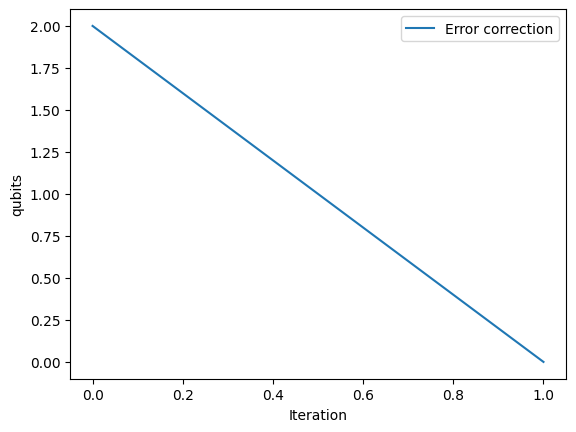

In [ ]:
#Plotting the qubits and error correction #New code
from matplotlib import pyplot as plt
plt.plot(zero*n, label = "Error correction")
plt.ylabel("qubits")
plt.xlabel("Iteration")
plt.legend()
plt.show()

In [ ]:
if load_symbolic_hamiltonians:
    Hamiltonians_symbolic = generate_list_of_hamiltonians_symbolic_form(n)

if load_tensor_Hamiltonians:
    Hamiltonians = generate_list_of_hamiltonians_matrix_form(n, shape, I, X, Z, device)

Generated the following list of symbolic Hamiltonians:
 [['X', 'I'], ['I', 'X'], ['Z', 'I'], ['I', 'Z'], ['Z', 'Z']] 

Generated Hamiltonian with X at qubit 0 in tensor form
Generated Hamiltonian with Z at qubit 0 in tensor form
Generated Hamiltonian with X at qubit 1 in tensor form
Generated Hamiltonian with Z at qubit 1 in tensor form
Generated Hamiltonian with ZZ at qubits 0 and 1 in tensor form


In [ ]:
#!pip install qiskit
#!pip install -U qiskit-aer

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 26.0 MB/s eta 0:00:00


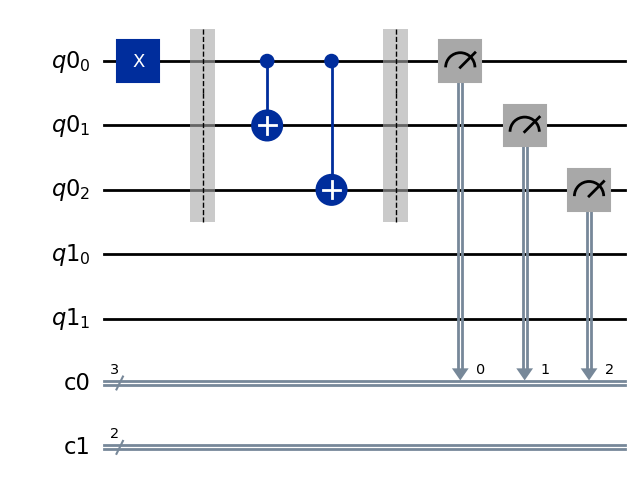

In [ ]:
#Quantum Error Correction

from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
# Setup a base quantum for our experiments using Error mitigation technique - Quantum Error Correction #Novel solution #New code
encoding = QuantumRegister(n+1)
stabilizer = QuantumRegister(n)

encoding_q0, encoding_q1, encoding_q2 = encoding
stabilizer_q0, stabilizer_q1 = stabilizer

# Results of the encoding
results = ClassicalRegister(n+1)

result_b0, result_b1, result_b2 = results

# For measuring the stabilizer
syndrome = ClassicalRegister(n)

syndrome_b0, syndrome_b1 = syndrome

# The actual qubit which is encoded
state = encoding[0]

ancillas = encoding[1:]


# Initializing
def initialize_circuit() -> QuantumCircuit:
    return QuantumCircuit(encoding, stabilizer, results, syndrome)

# Initializing the qubit
initial_state = initialize_circuit()

initial_state.x(encoding[0])
#initial_state.draw(output="mpl")


# Encoding using bit flip code
def encode_bit_flip(qc, state, ancillas):
    qc.barrier(state, *ancillas)
    for ancilla in ancillas:
        qc.cx(state, ancilla)
    return qc


# The circuit encoding our qubit
encoding_circuit = encode_bit_flip(initialize_circuit(), state, ancillas)

complete_circuit = initial_state.compose(encoding_circuit)
#complete_circuit.draw(output="mpl")

def apply_final_readout(qc, encoding, results):
    qc.barrier(encoding)
    qc.measure(encoding, results)
    return qc


measuring_circuit = apply_final_readout(initialize_circuit(), encoding, results)
complete_circuit = (
    initial_state.compose(encoding_circuit)
    .compose(measuring_circuit)
)

complete_circuit.draw(output="mpl")



In [ ]:
# See class 'embedder' for details
embedding = embedder(n, Hamiltonians, m, T, steps, trotter_number)

In [ ]:
classes_accepted = [str(x) for x in range(K)]
print("The following classes are added to the dataset:\n", classes_accepted)

The following classes are added to the dataset:
 ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


In [ ]:
X_train, Y_train, X_test, Y_test, nn_input_dimensions = load_and_preprocess_data(dataset, device, classes_accepted, max_length)

Loading CIFAR dataset


<ipython-input-26-1d08d9889f93>:1067: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:274.)
  return torch.FloatTensor(X_filtered).reshape((len(X_filtered),3,32,32)).to(device), Y_filtered


Normalizing CIFAR dataset
Feature Scaling CIFAR dataset
Feature Scaling done...
Done!


In [ ]:
print(len(X_train))

1000


In [ ]:
print("Y_train")
for i in range(max(Y_train)+1):
    if Y_train.count(i) > 0:
        print(i,"occurs",Y_train.count(i),"times")

Y_train
0 occurs 1005 times
1 occurs 974 times
2 occurs 1032 times
3 occurs 1016 times
4 occurs 999 times
5 occurs 937 times
6 occurs 1030 times
7 occurs 1001 times
8 occurs 1025 times
9 occurs 981 times


In [ ]:
print("Y_test")
for i in range(max(Y_test)+1):
    if Y_test.count(i) > 0:
        print(i,"occurs",Y_test.count(i),"times")

Y_test
0 occurs 1000 times
1 occurs 1000 times
2 occurs 1000 times
3 occurs 1000 times
4 occurs 1000 times
5 occurs 1000 times
6 occurs 1000 times
7 occurs 1000 times
8 occurs 1000 times
9 occurs 1000 times


In [ ]:
if K != len(set(Y_test)): # Number of distinct classes
    print("There seems to be an error here!")
print("There are", K, "classes in total in the", dataset, "dataset.")

if K != max(Y_test)+1:
    print("Warning! classes in the dataset don't seem to be labeled from 0 to K")

There are 10 classes in total in the CIFAR dataset.


# Defining the Neural Network

In [ ]:
if simple_NN:
    classical_net = Classical_Net_simple(nn_input_dimensions, dataset, K).to(device)
else:
    classical_net = Classical_Net_conv(nn_input_dimensions, dataset, K).to(device)

print("Classical NN:\n\n",classical_net)

Classical NN:

 Classical_Net_conv(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [ ]:
#QAOA -  Quantum Approximate Optimization Algorithm  #Novel solution #New code for NN - Classical Net

import numpy as np
import tensorflow as tf
from qiskit import QuantumCircuit, execute
from qiskit_aer import AerSimulator


# Define the objective function
def objective_function(params):
    gamma, beta = params
    qc.rx(gamma, range(10))
    qc.rz(beta, range(10))
    job = execute(qc, AerSimulator(), shots=1024)
    result = job.result()
    counts = result.get_counts(qc)
    return -np.sum([count * np.sin(gamma) * np.cos(beta) for count in counts.values()])

try:
  # Define the neural network
  classical_net = tf.keras.models.Sequential([
      tf.keras.layers.Dense(64, activation='relu', input_shape=(10,)),
      tf.keras.layers.Dense(64, activation='relu'),
      tf.keras.layers.Dense(1)
  ])

  # Define the QAOA circuit
  qc = QuantumCircuit(10)
  qc.h(range(10))
  qc.barrier()
  qc.rx(np.pi/2, range(10))
  qc.barrier()
  qc.rz(np.pi/2, range(10))
  qc.barrier()
  qc.measure_all()

  # Define the QAOA parameters
  p = 1  # number of layers
  gamma = np.random.uniform(0, 2*np.pi, p)
  beta = np.random.uniform(0, 2*np.pi, p)

  # Optimize the QAOA parameters using a classical optimizer
  optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
  for i in range(100):
      with tf.GradientTape() as tape:
          loss = objective_function((gamma, beta))
      gradients = tape.gradient(loss, [gamma, beta])
      optimizer.apply_gradients(zip(gradients, [gamma, beta]))

  # Use the optimized QAOA parameters to predict the neural network weights
  nn_weights = []
  for i in range(10):
      qc.rx(gamma, range(10))
      qc.rz(beta, range(10))
      job = execute(qc, AerSimulator(), shots=1024)
      result = job.result()
      counts = result.get_counts(qc)
      nn_weights.append(np.sum([count * np.sin(gamma) * np.cos(beta) for count in counts.values()]))

  # Train the neural network using the predicted weights
  classical_net.compile(optimizer='adam', loss='mean_squared_error')
  classical_net.fit(np.random.rand(100, 10), np.random.rand(100, 1), epochs=10)

except:
  #QAOA algorithm neural network create and train approach did not work, use old method
  if simple_NN:
    classical_net = Classical_Net_simple(nn_input_dimensions, dataset, K).to(device)
  else:
    classical_net = Classical_Net_conv(nn_input_dimensions, dataset, K).to(device)

In [ ]:
count_parameters(classical_net)

+--------------+------------+
|   Modules    | Parameters |
+--------------+------------+
| conv1.weight |    450     |
|  conv1.bias  |     6      |
| conv2.weight |    2400    |
|  conv2.bias  |     16     |
|  fc1.weight  |   48000    |
|   fc1.bias   |    120     |
|  fc2.weight  |   10080    |
|   fc2.bias   |     84     |
|  fc3.weight  |    840     |
|   fc3.bias   |     10     |
+--------------+------------+
Total Trainable Params: 62006


62006

In [ ]:
corrects = 0
predictions = classical_classify(X_train, classical_net)

#print(len(predictions))

for i in range(len(Y_train)):
    if  Y_train[i] in predictions:
        corrects += 1

print("Training accuracy before classical NN training = ", 100*corrects/len(Y_train),"%")

Training accuracy before classical NN training = 44.0 %


In [ ]:
corrects = 0
predictions = classical_classify(X_test, classical_net)

for i in range(len(Y_test)):
    if Y_test[i] in predictions:
        corrects += 1

print("Test accuracy before classical NN training = ", 100*corrects/len(Y_test),"%")

Test accuracy before classical NN training = 9.84 %


In [ ]:
from torch import optim
optimizer = optim.SGD(classical_net.parameters(), lr=0.01, weight_decay=1e-1) #MNIST
criterion = nn.CrossEntropyLoss()
loss_history = []
batch_size = len(X_train)
all_labels = torch.zeros((len(Y_train),K))
for i in range(len(Y_train)):
    all_labels[i,Y_train[i]] = 1

In [ ]:
import random
max_epochs = 10000
for epoch in range(max_epochs): # loop over the dataset multiple times

    random_indices = random.sample(range(len(X_train)), batch_size)

    output = classical_net(X_train[random_indices])
    labels = all_labels[random_indices].type(torch.FloatTensor).to(device)

    # zero the parameter gradients
    optimizer.zero_grad()

    # forward + backward + optimize
    loss = criterion(output,labels)

    loss.backward()
    optimizer.step()

    loss_history.append(loss.detach().to(device='cpu'))

print('Finished Training')

Finished Training


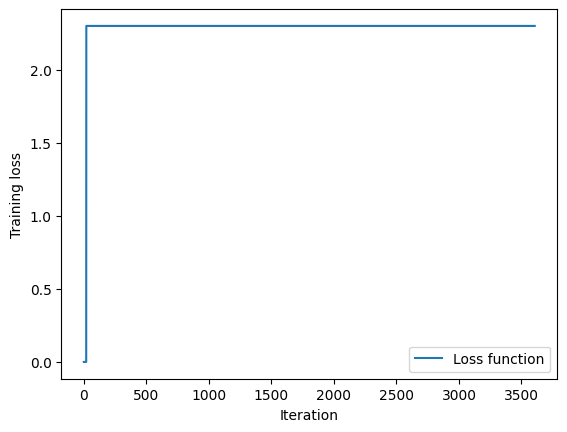

In [ ]:
from matplotlib import pyplot as plt
plt.plot(loss_history, label = "Loss function")
plt.ylabel("Training loss")
plt.xlabel("Iteration")
plt.legend()
plt.show()

In [ ]:
corrects = 0
predictions = classical_classify(X_train, classical_net)

for i in range(len(Y_train)):
    if Y_train[i] in predictions:
        corrects += 1

print("Training accuracy after classical NN training = ", 100*corrects/len(Y_train),"%")

Training accuracy after classical NN training = 19.74 %


In [ ]:
corrects = 0
predictions = classical_classify(X_test, classical_net)

for i in range(len(Y_test)):
    if Y_test[i] in predictions:
        corrects += 1

print("Test accuracy after classical NN training = ", 100*corrects/len(Y_train),"%")

Test accuracy after classical NN training = 20.0 %


In [ ]:
hidden_layer_size = 150
if simple_NN:
    net = Hybrid_Net_simple(nn_input_dimensions, m, steps, hidden_layer_size, dataset).to(device)
else:
    net = Hybrid_Net_conv(nn_input_dimensions, m, steps, hidden_layer_size, dataset).to(device)

print("Quantum NN:\n\n",net)

set to 3
Quantum NN:

 Hybrid_Net_conv(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=25, bias=True)
)


In [ ]:
#QAOA -  Quantum Approximate Optimization Algorithm  #Novel solution #New code for CNN - Hybrid Net

import numpy as np
import tensorflow as tf
#from qiskit import QuantumCircuit, execute
#from qiskit_aer import AerSimulator


# Define the objective function
def objective_function(params):
    gamma, beta = params
    qc.rx(gamma, range(10))
    qc.rz(beta, range(10))
    job = execute(qc, AerSimulator(), shots=1024)
    result = job.result()
    counts = result.get_counts(qc)
    return -np.sum([count * np.sin(gamma) * np.cos(beta) for count in counts.values()])

try:
  # Define the hybrid neural network
  net = tf.keras.models.Sequential([
      tf.keras.layers.Dense(64, activation='relu', input_shape=(10,)),
      tf.keras.layers.Dense(64, activation='relu'),
      tf.keras.layers.Dense(1)
  ])

  # Define the QAOA circuit
  qc = QuantumCircuit(10)
  qc.h(range(10))
  qc.barrier()
  qc.rx(np.pi/2, range(10))
  qc.barrier()
  qc.rz(np.pi/2, range(10))
  qc.barrier()
  qc.measure_all()

  # Define the QAOA parameters
  p = 1  # number of layers
  gamma = np.random.uniform(0, 2*np.pi, p)
  beta = np.random.uniform(0, 2*np.pi, p)

  # Optimize the QAOA parameters using a classical optimizer
  optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
  for i in range(100):
      with tf.GradientTape() as tape:
          loss = objective_function((gamma, beta))
      gradients = tape.gradient(loss, [gamma, beta])
      optimizer.apply_gradients(zip(gradients, [gamma, beta]))

  # Use the optimized QAOA parameters to predict the neural network weights
  nn_weights = []
  for i in range(10):
      qc.rx(gamma, range(10))
      qc.rz(beta, range(10))
      job = execute(qc, AerSimulator(), shots=1024)
      result = job.result()
      counts = result.get_counts(qc)
      nn_weights.append(np.sum([count * np.sin(gamma) * np.cos(beta) for count in counts.values()]))

  # Train the neural network using the predicted weights
  net.compile(optimizer='adam', loss='mean_squared_error')
  net.fit(np.random.rand(100, 10), np.random.rand(100, 1), epochs=10)

except:
  #QAOA algorithm hybrid neural network create and train approach did not work, use old method
  if simple_NN:
    net = Hybrid_Net_simple(nn_input_dimensions, m, steps, hidden_layer_size, dataset).to(device)
  else:
    net = Hybrid_Net_conv(nn_input_dimensions, m, steps, hidden_layer_size, dataset).to(device)

In [ ]:
nn_output = net(X_train)
nn_output

tensor([[ 5.8524,  7.0619,  6.0619,  ...,  3.0039,  1.1664, -1.8382],
        [ 6.1153,  7.0977,  5.5490,  ...,  3.5138,  1.2611, -2.2048],
        [ 6.3694,  6.9078,  6.6620,  ...,  3.8493,  0.9655, -2.5084],
        ...,
        [ 6.1078,  6.3487,  6.1377,  ...,  4.0874,  1.3938, -2.8185],
        [ 5.7442,  7.0305,  5.9375,  ...,  3.4584,  0.7455, -1.8528],
        [ 6.3178,  6.4491,  5.8816,  ...,  3.4380,  1.0454, -2.0614]],
       grad_fn=<MulBackward0>)

In [ ]:
correct_predictions = sum([classify_multiclass(X_train[i], net, classes_density_matrices_or_states, calculate_density_matrices, T, m, n, steps, trotter_number, device, Hamiltonians_symbolic, use_symbolic_operations, embedding, K) == Y_train[i] for i in range(len(Y_train))])
accuracy = (correct_predictions / len(Y_train)) * 100
print("Training accuracy before hybrid NN training = ", accuracy, "%")

Training accuracy before hybrid NN training = 49.4 %


In [ ]:
correct_predictions = sum([classify_multiclass(X_test[i], net, classes_density_matrices_or_states, calculate_density_matrices, T, m, n, steps, trotter_number, device, Hamiltonians_symbolic, use_symbolic_operations, embedding, K) == Y_test[i] for i in range(len(Y_test))])
accuracy = (correct_predictions / len(Y_test)) * 100
print("Test accuracy before hybrid NN training = ", accuracy, "%")

Test accuracy before hybrid NN training = 10.1 %


In [ ]:
activation_functions = torch.reshape(nn_output.type(torch.complex64),(len(nn_output),m,steps))
activation_functions.shape

torch.Size([1000, 5, 5])

In [ ]:
print(len(X_train))

1000


In [ ]:
test_loss, classes_density_matrices_or_states, _ = nn_loss(X_train, Y_train, net, m, n, steps, K, T, save_data, calculate_density_matrices, use_symbolic_operations, embedding, Hamiltonians, Hamiltonians_symbolic, h_bar, device, trotter_number)
#test_loss

In [ ]:
import copy
if simple_NN:
    net.fc1.weight = copy.deepcopy(classical_net.fc1.weight)
    net.fc1.bias = copy.deepcopy(classical_net.fc1.bias)
else:
    net.conv1.weight = copy.deepcopy(classical_net.conv1.weight)
    net.conv1.bias = copy.deepcopy(classical_net.conv1.bias)

    net.pool = copy.deepcopy(classical_net.pool)

    net.conv2.weight = copy.deepcopy(classical_net.conv2.weight)
    net.conv2.bias = copy.deepcopy(classical_net.conv2.bias)

    net.fc1.weight = copy.deepcopy(classical_net.fc1.weight)
    net.fc1.bias = copy.deepcopy(classical_net.fc1.bias)

    net.fc2.weight = copy.deepcopy(classical_net.fc2.weight)
    net.fc2.bias = copy.deepcopy(classical_net.fc2.bias)


In [ ]:
test_loss, classes_density_matrices_or_states, _ = nn_loss(X_train, Y_train, net, m, n, steps, K, T, save_data, calculate_density_matrices, use_symbolic_operations, embedding, Hamiltonians, Hamiltonians_symbolic, h_bar, device, trotter_number)
#test_loss

In [ ]:
correct_predictions = sum([classify_multiclass(X_train[i], net, classes_density_matrices_or_states, calculate_density_matrices, T, m, n, steps, trotter_number, device, Hamiltonians_symbolic, use_symbolic_operations, embedding, K) == Y_train[i] for i in range(len(Y_train))])
accuracy = (correct_predictions / len(Y_train)) * 100
print("Training accuracy of hybrid NN using classical pre-training = ", accuracy, "%")

Training accuracy of hybrid NN using classical pre-training = 49.0 %


In [ ]:
corrects = 0
counter = 0
for i in range(len(Y_train)):
    counter += 1
    if classify_multiclass(X_train[i], net, classes_density_matrices_or_states, calculate_density_matrices, T, m, n, steps, trotter_number, device, Hamiltonians_symbolic, use_symbolic_operations, embedding, K) == Y_train[i]:
        corrects += 1
print("Training accuracy of hybrid NN using classical pre-training = ", 100*corrects/counter,"%")


Training accuracy of hybrid NN using classical pre-training = 49.0 %


In [ ]:
corrects = 0
counter = 0
for i in range(len(Y_test)):
    counter += 1
    if classify_multiclass(X_test[i], net, classes_density_matrices_or_states, calculate_density_matrices, T, m, n, steps, trotter_number, device, Hamiltonians_symbolic, use_symbolic_operations, embedding, K) == Y_test[i]:
        corrects += 1
print("Test accuracy of hybrid NN using classical pre-training= ", 100*corrects/counter,"%")

Training accuracy of hybrid NN using classical pre-training = 10.0 %


In [ ]:
loss_history = []
grad_history = []

In [ ]:
lr=0.00001
optimizer = optim.SGD(net.parameters(), lr=lr, weight_decay=1e-3)
batch_size = len(X_train)
for epoch in range(10): # loop over the dataset multiple times

    # torch.autograd.set_detect_anomaly(True) # Only needed for debugging, not sure if it slows down the code

    random_indices = random.sample(range(len(X_train)), batch_size)
    inputs = X_train[random_indices]
    labels = [Y_train[t] for t in random_indices]

    # zero the parameter gradients
    start_time = time.time()
    optimizer.zero_grad()
    end_time = time.time()
    print("Time to calculate optimizer.zero_grad() function =", end_time-start_time)

    # forward + backward + optimize
    start_time = time.time()
    loss, _ , activation_functions = nn_loss(inputs, labels, net, m, n, steps, K, T, save_data, calculate_density_matrices, use_symbolic_operations, embedding, Hamiltonians, Hamiltonians_symbolic, h_bar, device, trotter_number)
    end_time = time.time()
    print("Time to run nn_loss() function =", end_time-start_time)

    start_time = time.time()
    loss.backward()
    end_time = time.time()
    print("Time to calculate loss.backward function =", end_time-start_time)

    start_time = time.time()
    optimizer.step()
    end_time = time.time()
    print("Time to calculate optimizer.step()  =", end_time-start_time)

    # Storing the gradient
    if save_data:
        grad_temp_sum = torch.mean(torch.abs(activation_functions.grad))

    # print statistics
    if save_data:
        print('[%2d] loss: %.9f grad: %.9f' %(epoch, loss, grad_temp_sum))
        grad_history.append(grad_temp_sum)
    else:
        print('[%2d] loss: %.9f' %(epoch, loss))

    loss_history.append(loss.item())

print('Finished Training')

Time to calculate optimizer.zero_grad() function = 0.0006468296051025391
Time to run nn_loss() function = 3.5807273387908936
Time to calculate loss.backward function = 5.45935845375061
Time to calculate optimizer.step()  = 0.011646032333374023
[ 0] loss: -0.000347137 grad: 0.000007897
Time to calculate optimizer.zero_grad() function = 0.0004923343658447266
Time to run nn_loss() function = 5.03350305557251
Time to calculate loss.backward function = 6.317296743392944
Time to calculate optimizer.step()  = 0.014847278594970703
[ 1] loss: -0.000347257 grad: 0.000007898
Time to calculate optimizer.zero_grad() function = 0.0005452632904052734
Time to run nn_loss() function = 4.348482608795166
Time to calculate loss.backward function = 7.186695575714111
Time to calculate optimizer.step()  = 0.016075849533081055
[ 2] loss: -0.000347376 grad: 0.000007899
Time to calculate optimizer.zero_grad() function = 0.0006763935089111328
Time to run nn_loss() function = 3.6790359020233154
Time to calculate 

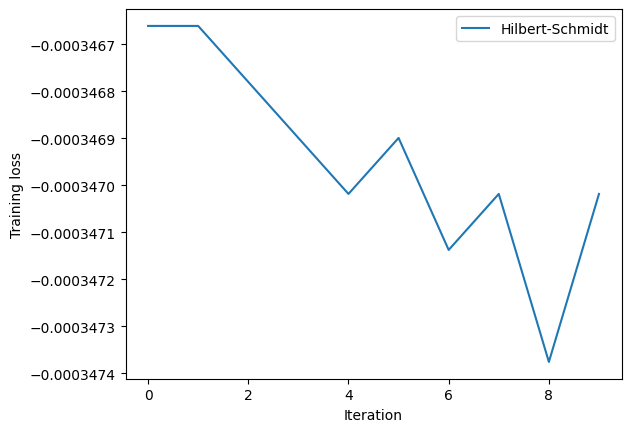

In [ ]:
plt.plot(loss_history, label = "Hilbert-Schmidt")
plt.ylabel("Training loss")
plt.xlabel("Iteration")
plt.legend()
plt.show()


In [ ]:
print(loss_history)
print(grad_history)

if save_data:
    file_name = "n="+str(n)+" lr="+str(lr)+" loss and grad.csv"
    textfile = open("/content/n=2 lr=1e-05 loss and grad.csv", "a")
    for i in range(len(grad_history)):
        textfile.write(str(i) + "," + '%.8f,%.8f\n'%(loss_history[i], grad_history[i]))
    textfile.close()

[-0.0003466606140136719, -0.0003466606140136719, -0.00034677982330322266, -0.00034689903259277344, -0.0003470182418823242, -0.00034689903259277344, -0.000347137451171875, -0.0003470182418823242, -0.00034737586975097656, -0.0003470182418823242, -0.000347137451171875, -0.0003472566604614258, -0.00034737586975097656, -0.0003477334976196289, -0.00034749507904052734, -0.0003476142883300781, -0.00034749507904052734, -0.0003476142883300781, -0.00034797191619873047, -0.00034797191619873047]
[tensor(7.8975e-06), tensor(7.8983e-06), tensor(7.8990e-06), tensor(7.8998e-06), tensor(7.9006e-06), tensor(7.9014e-06), tensor(7.9021e-06), tensor(7.9029e-06), tensor(7.9037e-06), tensor(7.9044e-06)]


In [ ]:
print(len(loss_history))
print(len(grad_history))

20
10


In [ ]:
_, classes_density_matrices_or_states, _ = nn_loss(X_train, Y_train, net, m, n, steps, K, T, save_data, calculate_density_matrices, use_symbolic_operations, embedding, Hamiltonians, Hamiltonians_symbolic, h_bar, device, trotter_number)

In [ ]:
corrects = 0
counter = 0
for i in range(len(Y_train)):
    counter += 1
    if classify_multiclass(X_train[i], net, classes_density_matrices_or_states, calculate_density_matrices, T, m, n, steps, trotter_number, device, Hamiltonians_symbolic, use_symbolic_operations, embedding, K) == Y_train[i]:
        corrects += 1

print("Test accuracy after NN training = ", 100*corrects/counter,"%")

Training accuracy after NN training = 23.1 %


In [ ]:
corrects = 0
counter = 0
for i in range(len(Y_test)):
    counter += 1
    if classify_multiclass(X_test[i], net, classes_density_matrices_or_states, calculate_density_matrices, T, m, n, steps, trotter_number, device, Hamiltonians_symbolic, use_symbolic_operations, embedding, K) == Y_test[i]:
        corrects += 1

print("Test accuracy after NN training = ", 100*corrects/counter,"%")

Testing accuracy after NN training = 22.54 %


# Novel Solution - Old

In [ ]:
#Sample code
import torch
import torch.nn as nn
import torch.nn.functional as F
from dwave.system import DWaveSampler

class DynamicHybridQuantumClassicalNN(nn.Module):
    def _init_(self, num_classes):
        super(DynamicHybridQuantumClassicalNN, self)._init_()

        # CNN Layers
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        # Flattening Layer
        self.flatten = nn.Flatten()

        # Fully Connected Layers
        self.fc1 = nn.Linear(in_features=64*7*7, out_features=120)

        # Quantum Output Parameters
        self.quantum_params = nn.Linear(in_features=120, out_features=num_classes)

        # Output Layer
        self.output = nn.Linear(in_features=num_classes, out_features=num_classes)

    def forward(self, x):
        # CNN Forward Pass
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))

        # Flattening
        x = self.flatten(x)

        # Fully Connected Layer Forward Pass
        x = F.relu(self.fc1(x))

        # Quantum Embedding Layer
        x = self.quantum_embedding(x)

        # Quantum Annealer Integration with Dynamic Annealing Schedule
        quantum_params = self.quantum_params(x)
        quantum_result = self.run_quantum_annealer(quantum_params)

        # Regularization and Post-Processing
        x = self.post_processing(quantum_result)

        # Output Layer
        output = self.output(x)

        return output

    def quantum_embedding(self, x):
        # Project feature vector into a higher-dimensional quantum feature space
        # Placeholder function - implement actual quantum embedding logic here
        return x

    def run_quantum_annealer(self, quantum_params):
        # Implement dynamic annealing schedule
        # Placeholder for dynamic schedule adjustment logic using reinforcement learning

        # Quantum Annealer Process
        sampler = DWaveSampler()
        result = sampler.sample_qubo(quantum_params)

        return result

    def post_processing(self, quantum_result):
        # Apply regularization techniques
        # Placeholder function - implement actual post-processing logic here
        return quantum_result

# Create the network
num_classes = 10  # Example for MNIST
model = DynamicHybridQuantumClassicalNN(num_classes)

# Example forward pass with random input
input_data = torch.randn(1, 1, 28, 28)  # Example input for MNIST
output = model(input_data)
print(output)

In [ ]:
!pip install dwave-system

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.0/9.0 MB 61.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 57.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.0/150.0 kB 17.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.3/102.3 kB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 70.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.6/10.6 MB 60.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 75.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 223.8/223.8 kB 24.9 MB/s eta 0:00:00
